# CNN on Custom Images

## Import Packages and Data Preparation

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
PATH = 'D:\Data Science Course\Anaconda\PyTorch\Cat_Dog_Classifier\CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(PATH,'train'), 
                                  transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(PATH,'test'), 
                                 transform=test_transform)

torch.manual_seed(40)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

class_names = train_data.classes
print(f'Class Category: {class_names}')
print(f'Train Data Length: {len(train_data)}')
print(f'Test Data Length: {len(test_data)}')

Class Category: ['CAT', 'DOG']
Train Data Length: 18743
Test Data Length: 6251


In [4]:
for images, labels in train_loader:
    break
    
images.shape

torch.Size([10, 3, 224, 224])

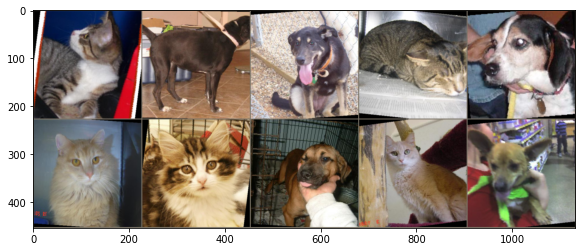

In [5]:
im = make_grid(images, nrow=5)

inv_normalize = transforms.Normalize(
    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std = [1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## CNN Model

In [7]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54 * 54 * 16, 120)
        self.fc2 = nn.Linear(120, 224)
        self.fc3 = nn.Linear(224, 2)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1, 54 * 54 * 16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [8]:
torch.manual_seed(101)
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=224, bias=True)
  (fc3): Linear(in_features=224, out_features=2, bias=True)
)

In [9]:
for i in model.parameters():
    print(i.numel())

162
6
864
16
5598720
120
26880
224
448
2


## Training Model

In [10]:
start = time.time()

epochs = 3

# Batch training 
max_train_batch = 800
max_test_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_correct_ = 0
    test_correct_ = 0
    
    for batch, (X_train, y_train) in enumerate(train_loader):
        
        if batch == max_train_batch:
            break
        
        batch += 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct_ += batch_correct
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 200 == 0:
            print(f'Epoch {i} -- Loss: {loss.item()}')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(train_correct_.detach().numpy())
    
    # Test our trained model
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            
            if batch == max_test_batch:
                break
            
            y_val = model(X_test)
            
            predicted = torch.max(y_pred.data, 1)[1]
            batch_correct = (predicted == y_test).sum()
            test_correct_ += batch_correct
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(test_correct_.detach().numpy())

end = time.time() - start
print('Total time: ', end/60)

Epoch 0 -- Loss: 0.6757198572158813
Epoch 0 -- Loss: 0.5398918390274048
Epoch 0 -- Loss: 0.8280493021011353
Epoch 0 -- Loss: 0.5981292128562927
Epoch 1 -- Loss: 0.6383122205734253
Epoch 1 -- Loss: 0.5389843583106995
Epoch 1 -- Loss: 0.5511690378189087
Epoch 1 -- Loss: 0.5391879677772522
Epoch 2 -- Loss: 0.511041522026062
Epoch 2 -- Loss: 0.40447384119033813
Epoch 2 -- Loss: 0.2559311091899872
Epoch 2 -- Loss: 0.8243227005004883
Total time:  21.97477581501007


## Evaluation
I decided to not fix the model performance considering this is just a practice and model train took lots of time.

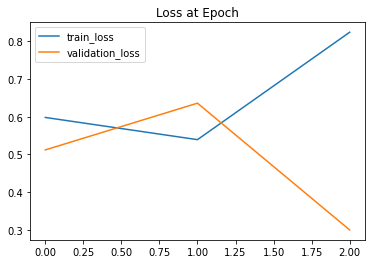

In [11]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='validation_loss')
plt.title('Loss at Epoch')
plt.legend();

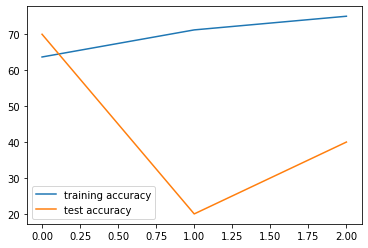

In [12]:
plt.plot([t/80 for t in train_correct], label = 'training accuracy')
plt.plot([t/30 for t in test_correct], label = 'test accuracy')
plt.legend();

In [13]:
print(f'Accuracy: {100 * test_correct[-1].item() / 3000}')

Accuracy: 40.0


## Saving Model

In [14]:
torch.save(model.state_dict(), 'my3epochmodel.pt')